In [1]:
from tqdm import tqdm
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import polars as pl


from app.data_gen.surface_gen import generate_130_point_iv_surface, generate_custom_130_point_iv_surface, generate_130_point_prices
from app.data_gen.sampling import sample_maturities, sample_moneyness

# Sampling Comparison

[  4   7  16  31  52  80 113 152 198 249 307 370 440]
[  4   7  11  17  25  36  53  76 108 154 219 311 440]
[  4   5   8  12  19  28  41  62  91 135 201 297 440]


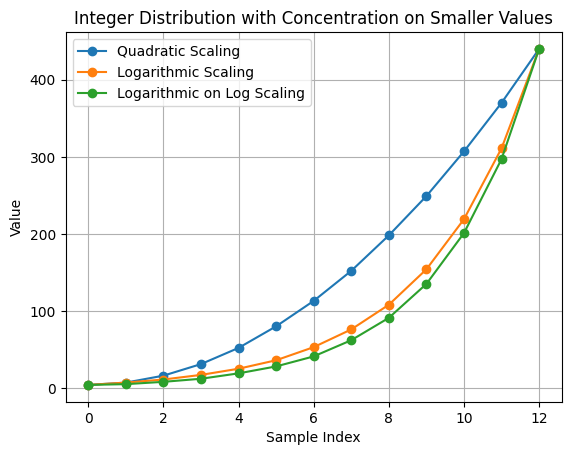

In [2]:
# Generate a quadratic-scaled range
values = np.linspace(0, 1, 13)**2 * (440 - 4) + 4
values = np.round(values).astype(int)  # Round to nearest integer
values = np.unique(values)  # Ensure unique integers

print(values)

# values_g = np.geomspace(4, 440, num=13).astype(int)
# values_g = np.unique(values_g)  # Ensure unique integers

# print(values_g)

values_l = (np.logspace(0, 1.8, 13, base=10) - 1) / (10**1.8 - 1) * (440 - 4) + 4
values_l = np.round(values_l).astype(int)
values_l = np.unique(values_l)

print(values_l)

values_a = np.logspace(np.log10(4), np.log10(440), num=13, dtype=int)

print(values_a)

plt.plot(values, marker='o', label='Quadratic Scaling')
# plt.plot(values_g, marker='o', label='Integer Distribution G')
plt.plot(values_l, marker='o', label='Logarithmic Scaling')
plt.plot(values_a, marker='o', label='Logarithmic on Log Scaling')
plt.title('Integer Distribution with Concentration on Smaller Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.show()

# Data Generation WARNING!: BIG COMPUTATION AHEAD

In [3]:
# Define constants
spot_price = 100
tau_grid = sample_maturities(10)  # Function to sample 10 maturities
moneyness_grid = sample_moneyness(13)  # Function to sample 13 moneyness levels

# Number of samples
num_samples = 600_000
batch_size = 10_000  # Generate data in smaller batches to manage memory

def generate_data_batch(batch_size, spot_price, moneyness_grid, tau_grid):
    return Parallel(n_jobs=-1, prefer='processes')(delayed(generate_130_point_iv_surface)(
        spot_price=spot_price,
        moneyness_grid=moneyness_grid,
        tau_grid=tau_grid
    ) for _ in range(batch_size))

def convert_dtypes_pl(data):
    pl_df = pl.DataFrame(data)
    tau_columns = [col for col in pl_df.columns if col.startswith('tau_')]
    float_columns = [col for col in pl_df.columns if col not in tau_columns and col != "implied_vol_surface"]
    
    pl_df = pl_df.with_columns(
        [pl.col(tau).cast(pl.Int16) for tau in tau_columns] +
        [pl.col(float_col).cast(pl.Float32) for float_col in float_columns] +
        [pl.col("implied_vol_surface").cast(pl.Array(pl.Float32, 130))]
    )
    return pl_df

def generate_large_dataset(num_samples, batch_size, spot_price, moneyness_grid, tau_grid, output_file):
    num_batches = num_samples // batch_size
    
    for batch_idx in tqdm(range(num_batches), desc="Generating Dataset Batches"):
        batch_data = generate_data_batch(batch_size, spot_price, moneyness_grid, tau_grid)
        df_batch = convert_dtypes_pl(batch_data)
        
        # Save batch to file incrementally
        if batch_idx == 0:
            df_batch.write_parquet(output_file, compression='snappy')
        else:
            # Append to Parquet by reading existing data, concatenating, and saving
            existing_df = pl.read_parquet(output_file)
            combined_df = pl.concat([existing_df, df_batch])
            combined_df.write_parquet(output_file, compression="snappy")
    
    print(f"Dataset saved to {output_file}")

# Generate the dataset
output_file = "ivs_dataset.parquet"
dataset = generate_large_dataset(
    num_samples=num_samples,
    batch_size=batch_size,
    spot_price=spot_price,
    moneyness_grid=moneyness_grid,
    tau_grid=tau_grid,
    output_file=output_file
)

Generating Dataset Batches: 100%|██████████| 60/60 [46:43<00:00, 46.72s/it]

Dataset saved to ivs_dataset.parquet


In [4]:
df = pl.read_parquet("ivs_dataset.parquet")
arr = np.array(df['implied_vol_surface'].to_numpy())
mask = np.any(np.isnan(arr), axis=1)
np.where(np.isnan(arr))

(array([  1917,  10045, 142821, 170351, 230483, 236803, 260000, 279549,
        287630, 303835, 372038, 377649, 433024, 443350, 462913, 494852,
        536643, 566845], dtype=int64),
 array([19,  6, 71,  6, 19, 98, 32, 32,  6, 32, 71, 45, 58, 58, 19, 32,  6,
         6], dtype=int64))

In [5]:
arr[1917]

array([0.55291426, 0.47321767, 0.39126676, 0.3068841 , 0.22524936,
       0.17995092, 0.17402603, 0.18135886, 0.21134761, 0.27040362,
       0.3345867 , 0.3947419 , 0.45039824, 0.35786855, 0.30635676,
       0.2588075 , 0.22532491, 0.20784914, 0.20412612,        nan,
       0.21803027, 0.24265917, 0.28758985, 0.34319392, 0.39900595,
       0.45159906, 0.4471668 , 0.38986453, 0.33489656, 0.28987032,
       0.26239523, 0.25005877, 0.24593498, 0.24613813, 0.24855705,
       0.25376105, 0.26344725, 0.27744186, 0.2949739 , 0.39091465,
       0.35577625, 0.32882825, 0.31127027, 0.3012418 , 0.29601124,
       0.2938274 , 0.29363662, 0.2946201 , 0.29641882, 0.2993731 ,
       0.3041016 , 0.3107967 , 0.4148876 , 0.3953773 , 0.38105705,
       0.37103835, 0.36426347, 0.35986742, 0.3572184 , 0.35583055,
       0.3553119 , 0.35537764, 0.35588834, 0.35686526, 0.35844883,
       0.4376414 , 0.430268  , 0.4246566 , 0.42042518, 0.41727814,
       0.4149908 , 0.4133846 , 0.41230974, 0.41163868, 0.41126

In [6]:
df.row(1917, named=True)

{'r': 0.03842781111598015,
 'q': 0.016924336552619934,
 'v0': 0.007655731867998838,
 'kappa': 7.4618353843688965,
 'theta': 0.3455517888069153,
 'sigma': 1.3989237546920776,
 'rho': -0.055929072201251984,
 'lambda_p': 0.11553233116865158,
 'tau_1': 7,
 'tau_2': 11,
 'tau_3': 17,
 'tau_4': 27,
 'tau_5': 44,
 'tau_6': 69,
 'tau_7': 110,
 'tau_8': 175,
 'tau_9': 277,
 'tau_10': 440,
 'm_1': 0.800000011920929,
 'm_2': 0.8333333134651184,
 'm_3': 0.8666666746139526,
 'm_4': 0.8999999761581421,
 'm_5': 0.9333333373069763,
 'm_6': 0.9666666388511658,
 'm_7': 1.0,
 'm_8': 1.0333333015441895,
 'm_9': 1.0666667222976685,
 'm_10': 1.100000023841858,
 'm_11': 1.1333333253860474,
 'm_12': 1.1666666269302368,
 'm_13': 1.2000000476837158,
 'nu_1': 0.00969337485730648,
 'nu_2': -0.2837226092815399,
 'nu_3': 0.18907585740089417,
 'nu_4': 0.27977800369262695,
 'nu_5': -0.20338156819343567,
 'delta_1': 0.24070769548416138,
 'delta_2': 0.2243366837501526,
 'delta_3': 0.23019711673259735,
 'delta_4': 0.290

## Custom Generation and Plotting

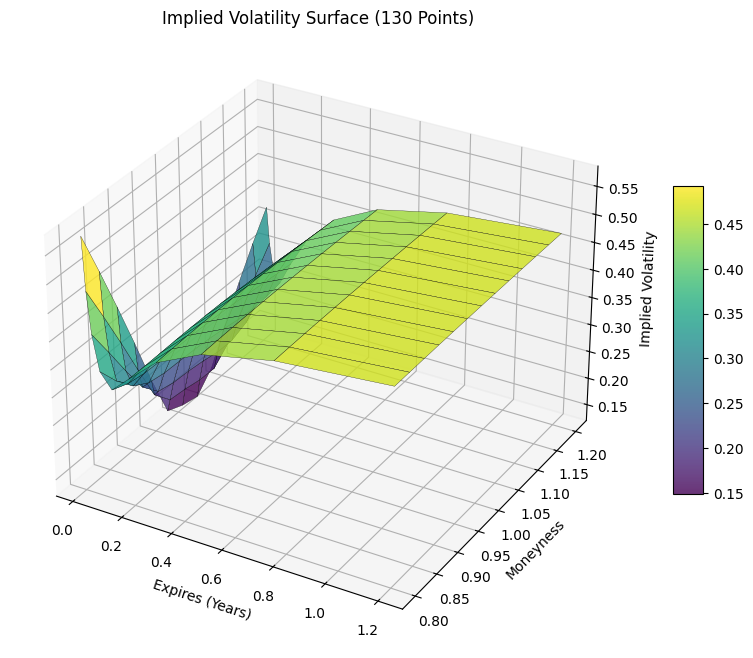

In [ ]:
from app.data_gen.models import GenerationParams

params = GenerationParams(
    moneyness_grid=sample_moneyness(13),
    tau_grid=sample_maturities(10),
    spot_price=100,
    r=0.0205,
    q=0.03,
    v0=0.0001,
    kappa=7.797,
    theta=0.247,
    sigma=0.280,
    rho=0.042,
    lambda_p=0.081,
    nu=0.159,
    delta=0.205)

data_point = generate_custom_130_point_iv_surface(params=params)

# Plot the surface
iv_matrix = np.array(data_point["implied_vol_surface"]).reshape(len(params.tau_grid), len(params.moneyness_grid))

X, Y = np.meshgrid(np.array(params.tau_grid) / 365.0, params.moneyness_grid)
fig = plt.figure(figsize=(12, 8))
ax: axes3d.Axes3D = fig.add_subplot(111, projection='3d') # type: ignore

surf = ax.plot_surface(X, Y, iv_matrix.T, cmap="viridis", edgecolor='k', linewidth=0.2, alpha=0.8)

cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('Implied Volatility', rotation=90, labelpad=15)

ax.set_title("Implied Volatility Surface (130 Points)")
ax.set_xlabel("Expires (Years)")
ax.set_ylabel("Moneyness")
ax.set_zlabel("Implied Volatility")
plt.show()

# Price Validation

In [ ]:
import numpy as np
from scipy.stats import norm
import pandas as pd

# Parameters
spot_price = 100
maturities = sample_maturities(10)
moneyness_values = sample_moneyness(13)

data_point = generate_130_point_prices(spot_price=spot_price, moneyness_grid=moneyness_values, tau_grid=maturities)

interest_rate = data_point['r']
dividend_rate = data_point['q']
volatility = np.array(data_point["iv_surface"]).reshape(len(maturities), len(moneyness_values))

# Modeled prices from Bates model
bates_prices = np.array(data_point["prices"]).reshape(len(maturities), len(moneyness_values)).T


# Black-Scholes formula
def black_scholes_call_price(S, K, T, r, q, sigma):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Calculate Black-Scholes prices
bs_prices = {}
for i, tau in enumerate(maturities):
    T = tau / 365  # Convert to years
    bs_prices[tau] = [
        black_scholes_call_price(
            S=spot_price,
            K=spot_price / m,  # Strike price based on moneyness
            T=T,
            r=interest_rate,
            q=dividend_rate,
            sigma=volatility[i][j],
        )
        for j, m in enumerate(moneyness_values)
    ]


bs_prices = pd.DataFrame(bs_prices, index=moneyness_values, dtype=np.float16)
bs_prices

,7,11,17,27,44,69,110,175,277,440
0.800000,0.012962,0.021286,0.035156,0.068176,0.201294,0.639160,1.756836,3.781250,6.761719,10.789062
0.833333,0.016678,0.027634,0.047943,0.112549,0.373779,1.054688,2.480469,4.769531,7.937500,12.062500
0.866667,0.021255,0.036896,0.077087,0.224609,0.700195,1.662109,3.371094,5.878906,9.179688,13.367188
0.900000,0.028793,0.064514,0.175293,0.498291,1.252930,2.484375,4.425781,7.093750,10.476562,14.687500
0.933333,0.072449,0.204102,0.489502,1.061523,2.089844,3.535156,5.636719,8.398438,11.828125,16.015625
0.966667,0.394531,0.735352,1.236328,2.023438,3.236328,4.808594,6.992188,9.789062,13.203125,17.359375
1.000000,1.519531,1.975586,2.566406,3.425781,4.691406,6.289062,8.468750,11.242188,14.617188,18.703125
1.033333,3.644531,3.982422,4.476562,5.242188,6.421875,7.945312,10.054688,12.750000,16.046875,20.031250
1.066667,6.363281,6.515625,6.812500,7.378906,8.375000,9.742188,11.718750,14.304688,17.484375,21.359375
1.100000,9.156250,9.210938,9.359375,9.718750,10.476562,11.648438,13.453125,15.882812,18.937500,22.687500


In [ ]:
bates_prices = pd.DataFrame(bates_prices, index=moneyness_values, columns=maturities)
bates_prices

,7,11,17,27,44,69,110,175,277,440
0.800000,0.021766,0.034683,0.055159,0.100597,0.264299,0.742015,1.881298,3.900218,6.864410,10.869975
0.833333,0.027226,0.043412,0.071686,0.153819,0.447901,1.152624,2.579459,4.858173,8.009228,12.122253
0.866667,0.033409,0.055167,0.106775,0.276423,0.773717,1.739802,3.439787,5.935210,9.225803,13.405237
0.900000,0.042746,0.087922,0.213980,0.551490,1.309761,2.535461,4.466194,7.123649,10.504770,14.711802
0.933333,0.092816,0.234832,0.525944,1.097623,2.119693,3.559146,5.654973,8.413113,11.836476,16.035317
0.966667,0.412214,0.751694,1.250439,2.033893,3.245107,4.814301,6.995325,9.791221,13.211267,17.369673
1.000000,1.519950,1.975121,2.566598,3.426603,4.692569,6.287634,8.470608,11.244341,14.619746,18.709323
1.033333,3.660799,3.997959,4.488382,5.253626,6.431009,7.951428,10.059975,12.758252,16.052951,20.049267
1.066667,6.383952,6.542626,6.844830,7.412673,8.400044,9.767995,11.740193,14.318770,17.502517,21.385063
1.100000,9.170569,9.239184,9.396666,9.764841,10.524685,11.694887,13.487315,15.912205,18.960740,22.712781


In [ ]:
(bates_prices-bs_prices).describe()

,7,11,17,27,44,69,110,175,277,440
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.013994,0.018272,0.025594,0.034525,0.044762,0.050375,0.049194,0.042776,0.038162,0.036234
std,0.005414,0.008234,0.011582,0.016790,0.026533,0.035770,0.040515,0.037293,0.031602,0.023108
min,0.000419,-0.000465,0.000192,0.000822,0.001163,-0.001429,0.001858,0.002153,0.002558,0.006198
25%,0.012153,0.015537,0.020003,0.032421,0.025044,0.023990,0.018254,0.014082,0.008351,0.019692
50%,0.014319,0.017252,0.027356,0.041183,0.056832,0.051086,0.040413,0.029899,0.028207,0.025688
75%,0.017683,0.023408,0.036369,0.046091,0.063432,0.077693,0.075700,0.069684,0.063598,0.049522
max,0.020671,0.030730,0.038687,0.053199,0.074122,0.102855,0.124462,0.118968,0.102691,0.080912


In [ ]:
lista = []
for _, row in (bates_prices- bs_prices).iterrows():
    lista.extend(row.to_list())
pd.Series(lista).describe()

count    130.000000
mean       0.035389
std        0.028272
min       -0.001429
25%        0.014090
50%        0.027179
75%        0.051462
max        0.124462
dtype: float64

# Dataset Comparison

In [ ]:
print('################## Dataset Size Comparison ####################')
print(f'Old pandas size: {764.5} MB')
print(f'New polars size: {384.5} MB')
print(f'Memory Reduction: x{764.5/384.5}', end='\n\n')

print("#################### File Size Comparison ####################")
print(f'Old csv size: {1881881318/(1024*1024)} MB')
print(f'New parquet size: {326702890/(1024*1024)} MB')
print(f'Memory Reduction: x{1881881318/326702890}')

################## Dataset Size Comparison ####################
Old pandas size: 764.5 MB
New polars size: 384.5 MB
Memory Reduction: x1.988296488946684

#################### File Size Comparison ####################
Old csv size: 1794.7018795013428 MB
New parquet size: 311.5681552886963 MB
Memory Reduction: x5.760222439415825


# Deprecated too big

In [ ]:
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

# Define constants
spot_price = 100
tau_grid = sample_maturities(10)  # Function to sample 10 maturities
moneyness_grid = sample_moneyness(13)  # Function to sample 13 moneyness levels

# Number of samples
num_samples = 600_000
batch_size = 10_000  # Generate data in smaller batches to manage memory

def generate_data_batch(batch_size, spot_price, moneyness_grid, tau_grid):
    return Parallel(n_jobs=-1, prefer='processes')(
        delayed(generate_130_point_iv_surface)(
            spot_price=spot_price,
            moneyness_grid=moneyness_grid,
            tau_grid=tau_grid
        )
        for _ in range(batch_size)
    )

def generate_large_dataset(num_samples, batch_size, spot_price, moneyness_grid, tau_grid, output_file):
    all_data = []
    num_batches = num_samples // batch_size
    
    for batch_idx in tqdm(range(num_batches), desc="Generating Dataset Batches"):
        batch_data = generate_data_batch(batch_size, spot_price, moneyness_grid, tau_grid)
        df_batch = pd.DataFrame(batch_data)
        
        # Save batch to file incrementally
        if batch_idx == 0:
            df_batch.to_csv(output_file, mode='w', index=False, header=True)
        else:
            df_batch.to_csv(output_file, mode='a', index=False, header=False)
        
        all_data.append(df_batch)
    
    return pd.concat(all_data, ignore_index=True)

# Generate the dataset
output_file = "bates_iv_surface_dataset.csv"
dataset = generate_large_dataset(
    num_samples=num_samples,
    batch_size=batch_size,
    spot_price=spot_price,
    moneyness_grid=moneyness_grid,
    tau_grid=tau_grid,
    output_file=output_file
)

print(f"Dataset saved to {output_file}")

Generating Dataset Batches: 100%|██████████| 60/60 [36:13<00:00, 36.23s/it]

Dataset saved to bates_iv_surface_dataset.csv


# Profiling

In [ ]:
import cProfile
import pstats

def profile_code():
    profiler = cProfile.Profile()
    profiler.enable()
    for i in range(10):
        generate_130_point_iv_surface(100, tau_grid=sample_maturities(10), moneyness_grid=sample_moneyness(13))
    
    profiler.disable()
    stats = pstats.Stats(profiler)
    stats.strip_dirs()
    stats.sort_stats("cumulative")  # Sort by cumulative time
    stats.print_stats(20)  # Print top 20 most time-consuming calls
    
profile_code()